In [ ]:
!pip install pot

Archive:  WGAN.zip
   creating: WGAN/
  inflating: WGAN/Losses.py          
  inflating: WGAN/NNs.py             
  inflating: WGAN/utils.py           
   creating: WGAN/__pycache__/
  inflating: WGAN/__pycache__/Losses.cpython-37.pyc  
  inflating: WGAN/__pycache__/NNs.cpython-37.pyc  
  inflating: WGAN/__pycache__/utils.cpython-37.pyc  
     |████████████████████████████████| 440kB 7.0MB/s 


In [ ]:
from WGAN.NNs import DiscriminatorMLP, DiscriminatorConvNet
from WGAN.utils import divide_by_classes, Trainer
from WGAN.Losses import GPLoss, WCLoss, WeightClipper, CEpsilonLoss, CLoss, LPLoss

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
import torchvision.utils as vutils

from torch.autograd import Variable
import torch.autograd as autograd

import torch.nn as nn
import torch.nn.functional as F
import torch

import numpy as np
from tqdm.notebook import tqdm

from itertools import product

import scipy.stats
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Resize((32, 32)),
    ]
)

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

import MNIST

--2021-03-23 19:42:12--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-23 19:42:12--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [     <=>            ]  33.20M  6.06MB/s    in 15s     

2021-03-23 19:42:28 (2.24 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [ ]:
datasets_names = ['CIFAR10', 'MNIST']
datasets_check = {'CIFAR10': (datasets.CIFAR10(root='cifar/', transform=transform, download=True, train=True),
                        datasets.CIFAR10(root='cifar/', transform=transform, download=True, train=False)),
            'MNIST': (datasets.MNIST(root = './', train=True, download=True, transform=transform),
                      datasets.MNIST(root = './', train=False, download=True, transform=transform))}

batch_sizes = list(product([64, 512], [64, 512]))

models = []

dataset_name = 'CIFAR10'
dataset_train, dataset_test = datasets_check[dataset_name]
N, M = batch_sizes[0]

train_part1, train_part2 = divide_by_classes(dataset_train, N, cifar=True)
test_part1, test_part2 = divide_by_classes(dataset_test, M, cifar=True)

check_image = next(iter(train_part1))

epochs = 20
num_of_channels = check_image.size(1)
image_size = check_image.size(2)


Extracting cifar/cifar-10-python.tar.gz to cifar/
Files already downloaded and verified


In [ ]:
discriminator = DiscriminatorConvNet(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = WCLoss()

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    weight_clipper=WeightClipper(0.2)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -6.589632



Val epoch 1 , Mean error : -5.960728



Val epoch 2 , Mean error : -5.4175736



Val epoch 3 , Mean error : -4.9982086



Val epoch 4 , Mean error : -4.4609334



Val epoch 5 , Mean error : -4.0168125



Val epoch 6 , Mean error : -3.5204499



Val epoch 7 , Mean error : -3.1981422



Val epoch 8 , Mean error : -2.7430469



Val epoch 9 , Mean error : -2.4645288



Val epoch 10 , Mean error : -1.9995952



Val epoch 11 , Mean error : -1.5701312



Val epoch 12 , Mean error : -1.3507566



Val epoch 13 , Mean error : -1.1042598



Val epoch 14 , Mean error : -0.88206637



Val epoch 15 , Mean error : -0.65623436



Val epoch 16 , Mean error : -0.44917274



Val epoch 17 , Mean error : -0.29138934



Val epoch 18 , Mean error : -0.19432292



Val epoch 19 , Mean error : -0.16074202


In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

Average error for conv is: 3.023+-0.105


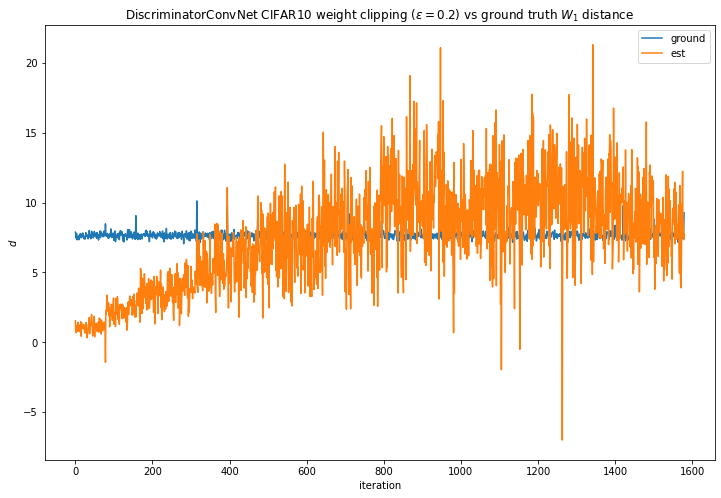

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} weight clipping $(\epsilon=0.2)$ vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for conv is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
discriminator = DiscriminatorConvNet(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = GPLoss(lambda_gp=10)
criterion.optimizer_params['lr'] = 0.01

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -9.8081902



Val epoch 1 , Mean error : -9.2702718



Val epoch 2 , Mean error : -9.027788



Val epoch 3 , Mean error : -8.9179575



Val epoch 4 , Mean error : -9.0680567



Val epoch 5 , Mean error : -9.109605



Val epoch 6 , Mean error : -9.6106342



Val epoch 7 , Mean error : -9.7789356



Val epoch 8 , Mean error : -10.032192



Val epoch 9 , Mean error : -10.137082



Val epoch 10 , Mean error : -10.095658



Val epoch 11 , Mean error : -10.037909



Val epoch 12 , Mean error : -9.9971682



Val epoch 13 , Mean error : -9.9880316



Val epoch 14 , Mean error : -10.026519



Val epoch 15 , Mean error : -9.9164852



Val epoch 16 , Mean error : -9.8881892



Val epoch 17 , Mean error : -9.8143141



Val epoch 18 , Mean error : -9.947



Val epoch 19 , Mean error : -9.9255263


Average error for mlp is: 9.926+-0.063


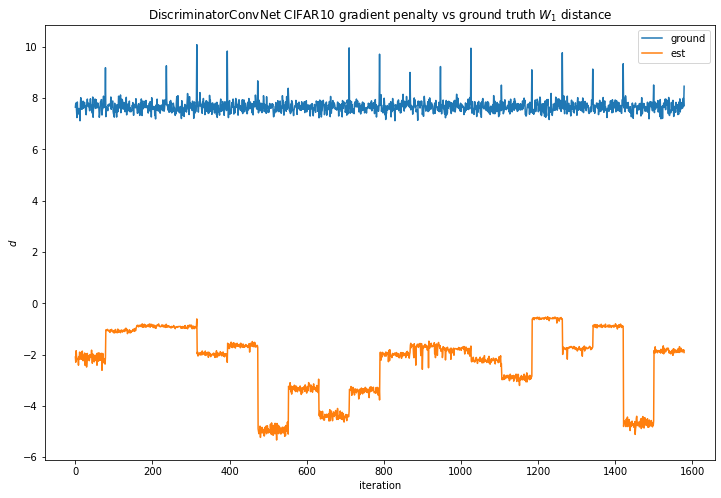

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} gradient penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
discriminator = DiscriminatorConvNet(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = LPLoss(lambda_gp=10)
criterion.optimizer_params['lr'] = 0.001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -14.330257



Val epoch 1 , Mean error : -11.84262



Val epoch 2 , Mean error : -10.531385



Val epoch 3 , Mean error : -9.8358718



Val epoch 4 , Mean error : -9.55326



Val epoch 5 , Mean error : -9.3711392



Val epoch 6 , Mean error : -9.1484306



Val epoch 7 , Mean error : -9.0426109



Val epoch 8 , Mean error : -8.8918283



Val epoch 9 , Mean error : -8.7806332



Val epoch 10 , Mean error : -8.6793813



Val epoch 11 , Mean error : -8.6270466



Val epoch 12 , Mean error : -8.5580447



Val epoch 13 , Mean error : -8.613486



Val epoch 14 , Mean error : -8.7372822



Val epoch 15 , Mean error : -8.7848342



Val epoch 16 , Mean error : -8.7821265



Val epoch 17 , Mean error : -8.8841161



Val epoch 18 , Mean error : -9.6498618



Val epoch 19 , Mean error : -9.7611901


Average error for mlp is: 9.761+-0.18


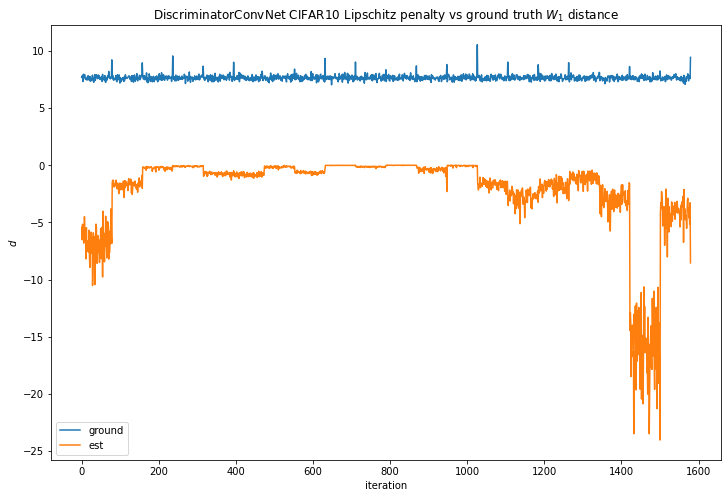

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} Lipschitz penalty vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
discriminator = DiscriminatorConvNet(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = CLoss()
criterion.optimizer_params['lr'] = 0.001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : -0.4775967



Val epoch 1 , Mean error : -0.46090014



Val epoch 2 , Mean error : -0.42452184



Val epoch 3 , Mean error : -0.40442866



Val epoch 4 , Mean error : -0.40395179



Val epoch 5 , Mean error : -0.39034907



Val epoch 6 , Mean error : -0.38653974



Val epoch 7 , Mean error : -0.37991638



Val epoch 8 , Mean error : -0.3787284



Val epoch 9 , Mean error : -0.37517321



Val epoch 10 , Mean error : -0.36846795



Val epoch 11 , Mean error : -0.36360388



Val epoch 12 , Mean error : -0.36085325



Val epoch 13 , Mean error : -0.35801927



Val epoch 14 , Mean error : -0.35454499



Val epoch 15 , Mean error : -0.35060822



Val epoch 16 , Mean error : -0.34861728



Val epoch 17 , Mean error : -0.34551088



Val epoch 18 , Mean error : -0.34385301



Val epoch 19 , Mean error : -0.34416815


Average error for mlp is: 0.344+-0.006


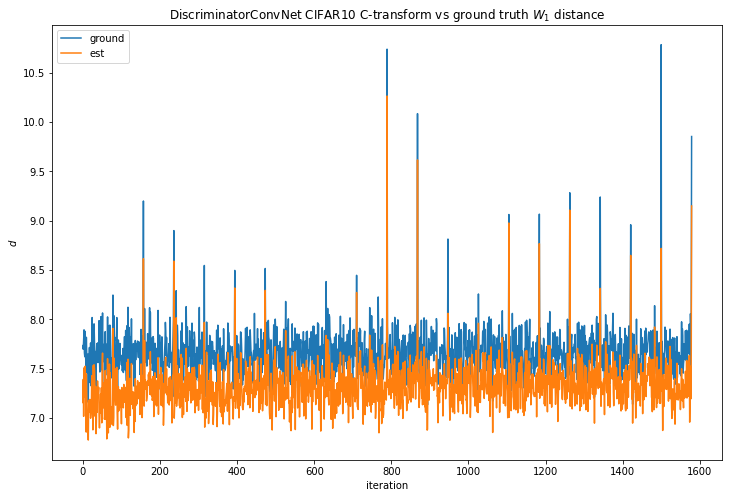

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} C-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()

In [ ]:
discriminator = DiscriminatorConvNet(image_size=image_size, num_of_channels=num_of_channels)
if cuda:
    discriminator.cuda()

criterion = CEpsilonLoss(1)
criterion.optimizer_params['lr'] = 0.0001

trainer = Trainer(
    criterion=criterion,
    train_part1=train_part1,
    train_part2=train_part2,
    test_part1=test_part1,
    test_part2=test_part2,
    discriminator=discriminator,
    # weight_clipper=WeightClipper(0.05)
)

val_dest, val_ground = trainer.train(20, device)


Val epoch 0 , Mean error : 1.8036067



Val epoch 1 , Mean error : 1.8051737



Val epoch 2 , Mean error : 1.8061508



Val epoch 3 , Mean error : 1.8034065



Val epoch 4 , Mean error : 1.7975039



Val epoch 5 , Mean error : 1.8005533



Val epoch 6 , Mean error : 1.8034935



Val epoch 7 , Mean error : 1.8032123



Val epoch 8 , Mean error : 1.803538



Val epoch 9 , Mean error : 1.8046567



Val epoch 10 , Mean error : 1.8066289



Val epoch 11 , Mean error : 1.8064705



Val epoch 12 , Mean error : 1.8049061



Val epoch 13 , Mean error : 1.8055341



Val epoch 14 , Mean error : 1.8053998



Val epoch 15 , Mean error : 1.8059674



Val epoch 16 , Mean error : 1.8071138



Val epoch 17 , Mean error : 1.8071143



Val epoch 18 , Mean error : 1.8057804



Val epoch 19 , Mean error : 1.8065604


Average error for mlp is: 1.807+-0.007


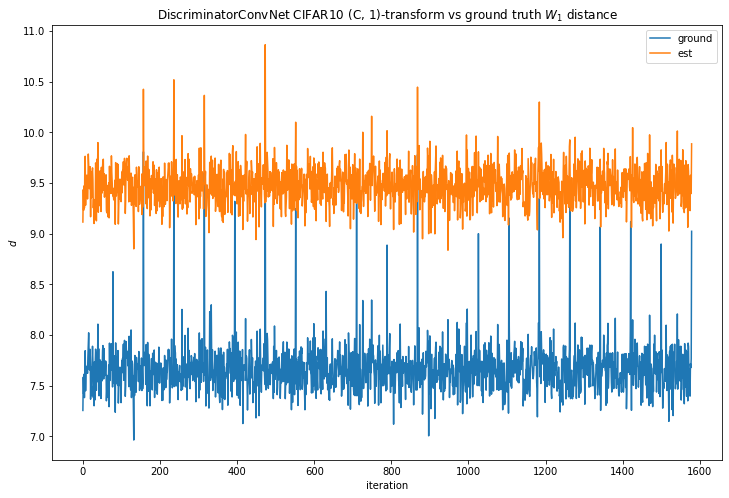

In [ ]:
with PdfPages(r'{}_{}_{}.pdf'.format(discriminator.__class__.__name__, dataset_name, criterion.__class__.__name__)) as export_pdf:
    plt.figure(figsize=(12, 8));
    plt.title(r"{} {} (C, 1)-transform vs ground truth $W_1$ distance".format(discriminator.__class__.__name__, dataset_name));
    plt.plot(val_ground, label="ground");
    plt.plot(val_dest, label="est");
    plt.ylabel(r"$d$");
    plt.xlabel("iteration")
    plt.legend();
    mean_conv, error_conv = mean_confidence_interval(np.abs(np.array(val_ground)-np.array(val_dest)))
    print(f"Average error for mlp is: {np.round(mean_conv,3)}+-{np.round(error_conv, 3)}")
    export_pdf.savefig()